In [1]:
from cluster_function import *

In [2]:
def load_trajectory(name):
    pdb = 'Tau5R2R3_'+name+'.pdb'
    trajname = 'Tau5R2R3_'+name+'.xtc'
    # traj = md.load(traj_dir+trajname, top=traj_dir+pdb, stride = 10)
    # For testing
    traj = md.load(traj_dir+trajname, top=traj_dir+pdb, stride=10)
    top = traj.topology
    print(traj)
    return top, traj


# Inputs for TSNE: provide distance matrix between all pairs of conformations. The RMSD.dat that I am using in the next line is the pairwise RMSD obtained from Gromacs in binary vector format.
workdir = './'
traj_dir = workdir + 'trajectory/'
all_out_dir = workdir + 'com_CYECYE7_out/'
traj_out_dir = traj_dir + 'com_CYECYE7_out/'
if not os.path.exists(all_out_dir):
    os.makedirs(all_out_dir)
if not os.path.exists(traj_out_dir):
    os.makedirs(traj_out_dir)

In [3]:
def calculate_tsne(name, traj):
    outdir = workdir + name + '/'
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    rmsd = np.empty((traj.n_frames, traj.n_frames))
    for i in range(traj.n_frames):
        rmsd[i] = md.rmsd(traj, traj, i)
    print('Max pairwise rmsd: %f nm' % np.max(rmsd))
    rmsd_sym = suv.check_symmetric(rmsd, raise_exception=False)

    with open(outdir + 'status.txt', 'a') as f1:
        f1.write("\n")
        print('symmetry check completed', file=f1)

    # Kmeans clustering
    range_n_clusters = [4, 6, 8, 10, 12, 14, 16, 18, 20]
    perplexityVals = range(100, 2100, 100)

    # Creating the TSNE object and projection
    perplexityVals = range(100, 2100, 100)

    for i in perplexityVals:
        tsneObject = TSNE(n_components=2, perplexity=i, early_exaggeration=10.0, learning_rate=100.0, n_iter=3500,
                          n_iter_without_progress=300, min_grad_norm=1e-7, metric="precomputed", init='random', method='barnes_hut', angle=0.5)
        # metric is precomputed RMSD distance. if you provide Raw coordinates, the TSNE will compute the distance by default with Euclidean metrics
        tsne = tsneObject.fit_transform(rmsd_sym)
        np.savetxt(outdir + "tsnep{0}".format(i), tsne)

    for perp in perplexityVals:
        tsne = np.loadtxt(outdir + 'tsnep'+str(perp))
        for n_clusters in range_n_clusters:
            kmeans = KMeans(n_clusters=n_clusters).fit(tsne)
            np.savetxt(outdir + 'kmeans_'+str(n_clusters)+'clusters_centers_tsnep' +
                       str(perp), kmeans.cluster_centers_, fmt='%1.3f')
            np.savetxt(outdir + 'kmeans_'+str(n_clusters)+'clusters_tsnep' +
                       str(perp)+'.dat', kmeans.labels_, fmt='%1.1d')
    # Compute silhouette score based on low-dim and high-dim distances
            silhouette_ld = silhouette_score(tsne, kmeans.labels_)
            np.fill_diagonal(rmsd_sym, 0)
            silhouette_hd = metrics.silhouette_score(
                rmsd_sym, kmeans.labels_, metric='precomputed')
            with open(outdir + 'silhouette.txt', 'a') as f:
                f.write("\n")
                print(perp, n_clusters, silhouette_ld, silhouette_hd,
                      silhouette_ld*silhouette_hd, file=f)


In [4]:
traj_name_list = ['apo', 'epi002', 'epi7170', 'CYE', 'CYE7']

apo_top, apo_traj = load_trajectory('apo')
epi002_top, epi002_traj = load_trajectory('epi002')
epi7170_top, epi7170_traj = load_trajectory('epi7170')
CYE_top, CYE_traj = load_trajectory('CYE')
CYE7_top, CYE7_traj = load_trajectory('CYE7')


<mdtraj.Trajectory with 5715 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 4951 frames, 793 atoms, 59 residues, and unitcells>
<mdtraj.Trajectory with 5516 frames, 800 atoms, 59 residues, and unitcells>
<mdtraj.Trajectory with 5975 frames, 791 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 5687 frames, 798 atoms, 58 residues, and unitcells>


In [5]:
def get_CA_trajectory(top, traj, name):
    ca_selection = top.select('name CA')
    traj_new = traj.atom_slice(ca_selection)
    print(traj_new)
    md.Trajectory.save_dcd(traj_new, traj_dir + '%s_CA.dcd' % name)
    return traj_new


apo_CA = get_CA_trajectory(apo_top, apo_traj, 'apo')
epi002_CA = get_CA_trajectory(epi002_top, epi002_traj, 'epi002')
epi7170_CA = get_CA_trajectory(epi7170_top, epi7170_traj, 'epi7170')
CYE_CA = get_CA_trajectory(CYE_top, CYE_traj, 'CYE')
CYE7_CA = get_CA_trajectory(CYE7_top, CYE7_traj, 'CYE7')

apo_CA_sel = apo_top.select('name CA')
apo_CA_traj_new = apo_traj.atom_slice(apo_CA_sel)
md.Trajectory.save_pdb(apo_CA_traj_new[0], traj_dir + 'apo_CA.pdb')


<mdtraj.Trajectory with 5715 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 4951 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 5516 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 5975 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 5687 frames, 56 atoms, 56 residues, and unitcells>


In [6]:
traj_1 = md.load(traj_dir+'apo_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_2 = md.load(traj_dir+'epi002_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_3 = md.load(traj_dir+'epi7170_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_4 = md.load(traj_dir+'CYE_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_5 = md.load(traj_dir+'CYE7_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_CA_combined = md.join([traj_4, traj_5])
top_CA_combined = traj_CA_combined.topology
print(traj_CA_combined)


<mdtraj.Trajectory with 11662 frames, 56 atoms, 56 residues, and unitcells>


In [7]:
ligand_residue_index_list = [58, 58, 14, 14]
contact_traj_list = [epi002_traj, epi7170_traj, CYE_traj, CYE7_traj]
ligand_ring_list = [[[759, 757, 753, 747, 752, 756], [751, 746, 750, 754, 758, 755]], [[759, 760, 761, 763, 771, 773], [757, 758, 742, 743, 744, 745]], [[200, 201, 202, 203, 211, 212], [193, 194, 195, 196, 213, 214]], [[200, 201, 202, 203, 210, 211], [193, 194, 195, 196, 213, 212]]]
ligand_hbond_donor_list = [[[744, 792], [742, 790], [743, 791]], [[768, 796], [750, 784], [752, 787]], [[210, 235], [208, 232], [190, 217]], [[208, 231], [190, 216]]]
ligand_residue_index_list = ligand_residue_index_list[2:4]
contact_traj_list = contact_traj_list[2:4]
ligand_ring_list = ligand_ring_list[2:4]
ligand_hbond_donor_list = ligand_hbond_donor_list[2:4]

contact_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    contact = calc_contact(t, l)
    contact_array = np.append(contact_array, contact, axis=0)
contact_array = np.delete(contact_array, 0, 0)

hphob_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    hphob = calc_hphob(t, l)
    hphob_array = np.append(hphob_array, hphob, axis=0)
hphob_array = np.delete(hphob_array, 0, 0)

aromatic_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_ring_list):
    aromatic = calc_aromatic(t, l)
    aromatic_array = np.append(aromatic_array, aromatic, axis=0)
aromatic_array = np.delete(aromatic_array, 0, 0)

hbond_array = np.empty([1, 58])
for t,l,d in zip(contact_traj_list, ligand_residue_index_list, ligand_hbond_donor_list):
    hbond = calc_hbond(t, l, d)
    hbond_array = np.append(hbond_array, hbond, axis=0)
hbond_array = np.delete(hbond_array, 0, 0)

print(contact_array.shape, hphob_array.shape, aromatic_array.shape, hbond_array.shape)

Lig_ring.0
Lig_ring.1
Lig_ring.0
Lig_ring.1
(11662, 58) (11662, 58) (11662, 58) (11662, 58)


In [11]:
def calc_hphob_temp(trj, ligand_residue_index):
    top = trj.topology
    n_frames = trj.n_frames
    residues = 58
    ligand_hphob = top.select("residue %s and element C" % str(ligand_residue_index))
    protein_hphob = top.select("protein and element C")
    print(ligand_hphob)
    # print the atom name of from ligand hphob atom number
    for i in range(len(ligand_hphob)):
        print(top.atom(ligand_hphob[i]).name)
    
    hphob_pairs = []
    for i in ligand_hphob:
        for j in protein_hphob:
            hphob_pairs.append([i, j])


    contact = md.compute_distances(trj, hphob_pairs)
    contacts = np.asarray(contact).astype(float)
    cutoff = 0.4
    contact_frames = np.where(contacts < cutoff, 1, 0)
    contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames

    Hphob_res_contacts = np.zeros((n_frames, residues))
    for frame in range(n_frames):
        if np.sum(contact_frames[frame]) > 0:
            contact_pairs = np.where(contact_frames[frame] == 1)
            for j in contact_pairs[0]:
                residue = top.atom(hphob_pairs[j][1]).residue.resSeq
                Hphob_res_contacts[frame][residue] = 1

    return Hphob_res_contacts

hphob_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    hphob = calc_hphob_temp(t, l)
    hphob_array = np.append(hphob_array, hphob, axis=0)
hphob_array = np.delete(hphob_array, 0, 0)



[179 181 185 187 188 191 193 194 195 196 197 198 199 200 201 202 203 205
 206 209 211 212 213 214]
CA
CB
C
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23
C24
[179 181 185 187 188 191 193 194 195 196 197 198 199 200 201 202 203 205
 206 209 210 211 212 213 219 237 243]
CA
CB
C
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21
C22
C23
C24
Cl1
Cl2
C25


In [8]:
h_res = []
for res in apo_traj.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 390
hres_renum = np.asarray(h_res)+residue_offset

apo_dssp = md.compute_dssp(apo_traj, simplified=True)
apo_dssp_array = np.array(apo_dssp)
epi002_dssp = md.compute_dssp(epi002_traj, simplified=True)[:, 0:58]
epi7170_dssp = md.compute_dssp(epi7170_traj, simplified=True)[:, 0:58]
CYE_dssp = md.compute_dssp(CYE_traj, simplified=True)[:, 0:58]
CYE7_dssp = md.compute_dssp(CYE7_traj, simplified=True)[:, 0:58]
dssp_all = np.concatenate(
    (CYE_dssp, CYE7_dssp))
dssp_all_H, dssp_all_E = dssp_convert(dssp_all)

helixpdb = './trajectory/R2R3_all_helix.pdb'
helixBB = md.load_pdb(helixpdb)

Sa_total = calc_Sa(traj_CA_combined, helixBB)
rg_CA = calc_rg(traj_CA_combined)

contact_map_apo = contact_map(apo_traj)
contact_map_epi002 = contact_map(epi002_traj)
contact_map_epi7170 = contact_map(epi7170_traj)
contact_map_CYE = contact_map(CYE_traj)
contact_map_CYE7 = contact_map(CYE7_traj)


KeyboardInterrupt: 

In [9]:
# calculate_tsne('com_CYECYE7_cluster_tsne', traj_CA_combined)


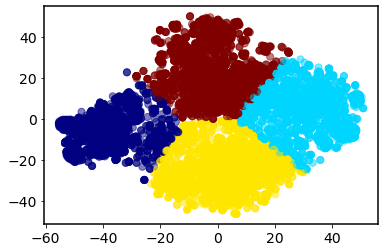

<Figure size 432x288 with 0 Axes>

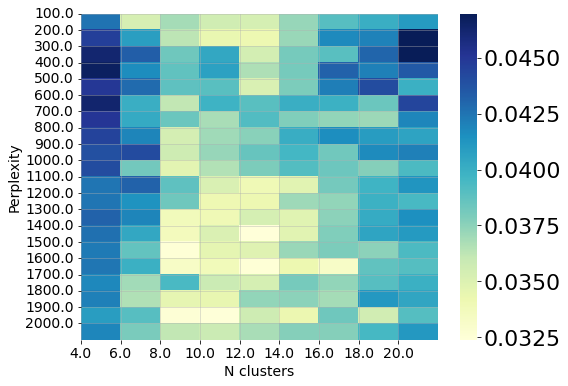

In [10]:
outdir = workdir + 'com_CYECYE7_cluster_tsne/'
range_n_clusters = [4, 6, 8, 10, 12, 14, 16, 18, 20]

##### plotting for the best cluster with highest silhouette score######
s = np.loadtxt(outdir + 'silhouette.txt')
[bestP, bestK] = [400, 4]
besttsne = np.loadtxt(outdir + 'tsnep'+str(int(bestP)))
bestclust = np.loadtxt(outdir + 'kmeans_'+str(int(bestK)) +
                       'clusters_tsnep'+str(int(bestP))+'.dat')
plt.rc('font', family='sans-serif', weight='normal', size='14')
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)
plt.scatter(besttsne[:, 0], besttsne[:, 1],
            c=bestclust.astype(float), s=50, alpha=0.5, cmap=cmap)
plt.savefig(outdir + 'tsnep'+str(int(bestP)) +
            '_kmeans'+str(int(bestK))+'.png', dpi=300)
plt.savefig(all_out_dir + 'tsnep'+str(int(bestP)) +
            '_kmeans'+str(int(bestK))+'.png', dpi=300)
plt.savefig(all_out_dir + 'tsnep'+str(int(bestP)) +
            '_kmeans'+str(int(bestK))+'.pdf', dpi=300)
plt.show()

plt.clf()

len(s[:, 4])
n_cluster_columns = np.reshape(s[:, 1], (20, len(range_n_clusters)))[0]
perp_columns = np.reshape(s[:, 0], (20, len(range_n_clusters)))[:, 0]
sil_score = np.reshape(s[:, 4], (20, len(range_n_clusters)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(sil_score, cmap='YlGnBu', ax=ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
plt.yticks(range(0, 20), perp_columns, rotation=0, size=14)
plt.xticks(range(0, 9), n_cluster_columns, rotation=0, size=14)
plt.xlabel("N clusters")
plt.ylabel("Perplexity")

#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
# ax.invert_xaxis()
len(perp_columns)
plt.savefig(all_out_dir + 'silhouette_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'silhouette_heatmap.pdf',
            dpi=300, bbox_inches='tight')


In [11]:
bestclust_int = bestclust.astype(int)
c_members = {i: np.where(bestclust_int == i)[0] for i in range(int(bestK))}
with open('c_members'+str(bestK)+'.txt', 'w') as f:
    print(c_members, file=f)


def find_indices(list_to_check, item_to_find):
    array = np.array(list_to_check)
    indices = np.where(array == item_to_find)[0]
    return list(indices)


cdef = {}
clusters = []
for x in bestclust_int:
    if x not in clusters:
        clusters.append(x)
print(clusters)
n_cluster = len(clusters)

c_dict = {}
for i in clusters:
    ind = find_indices(bestclust_int, i)
    c_dict[i] = np.array(ind)

for key in c_dict:
    print(len(c_dict[key]))
    print(len(c_dict[key])/len(bestclust_int))

average_H1_H = np.zeros((n_cluster, 3))
for key in c_dict:
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
    average_H1_H[key, 0] = key
    average_H1_H[key, 1] = np.mean(H1_H[:, 0])

sort_H = np.sort(average_H1_H[:, 1])
for i in range(len(sort_H)):
    index = np.where(average_H1_H[:, 1] == sort_H[i])[0]
    average_H1_H[index, 2] = int(n_cluster-i)
print(average_H1_H)


[2, 0, 1, 3]
3324
0.28502829703309895
2291
0.1964500085748585
2869
0.24601269079060195
3178
0.2725090036014406


/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


[[0.         0.12023059 4.        ]
 [1.         0.31017656 3.        ]
 [2.         0.31743537 2.        ]
 [3.         0.3363805  1.        ]]


In [12]:
traj_len_array = np.array([traj_4.n_frames, traj_5.n_frames])
cmap = cm.get_cmap('jet', int(bestK))
# marker_list = ['o', '+', 's', 'x', 'D']
# title_list = ['Apo', 'EPI-002', 'EPI-7170',
#               'CYS404 : EPI-002', 'CYS404 : EPI-7170']
# color_list = ['red', 'C0', 'C1', 'C2', 'C4']
marker_list = ['s', 'D']
title_list = [ 'CYS404 : EPI-002', 'CYS404 : EPI-7170']
color_list = ['C2', 'C4',]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

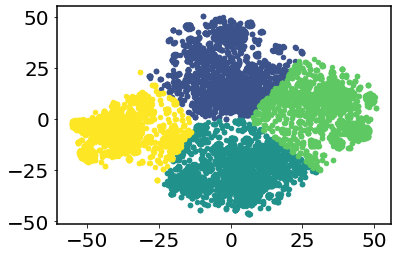

In [97]:
##### plotting for the best cluster with highest silhouette score######
s = np.loadtxt(outdir + 'silhouette.txt')
[bestP, bestK] = [400, 4]
besttsne = np.loadtxt(outdir + 'tsnep'+str(int(bestP)))
bestclust = np.loadtxt(outdir + 'kmeans_'+str(int(bestK)) +
                       'clusters_tsnep'+str(int(bestP))+'.dat')
# plt.figure(figsize=(8, 6))
plt.rc('font', family='sans-serif', weight='normal', size=14)
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)

for i in range(1, n_cluster+1):
    index = np.where(average_H1_H[:, 2] == i)[0]
    plt.scatter(besttsne[np.where(bestclust == index)[0], 0], besttsne[np.where(
        bestclust == index)[0], 1], s=20, alpha=1, c=plt.cm.viridis(round(256/n_cluster)*(i)), label='C'+str(i))

plt.tick_params(axis='both', labelsize=20)
plt.savefig(all_out_dir + 'tsne_color.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'tsne_color.pdf', dpi=300, bbox_inches='tight')

In [14]:
count = 0
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    count = count + traj_len_array[i]
    print('For ' + title_list[i] + ':')
    for c_num in range(0, n_cluster):
        perct = np.where(bestcluster == c_num)[0].shape[0]/bestcluster.shape[0]
        print('In cluster ' + str(c_num) + ': ' + str(perct))


For CYS404 : EPI-002:
In cluster 0: 0.24217573221757321
In cluster 1: 0.23815899581589958
In cluster 2: 0.24803347280334728
In cluster 3: 0.2716317991631799
For CYS404 : EPI-7170:
In cluster 0: 0.14840865131000527
In cluster 1: 0.25426411113064884
In cluster 2: 0.3238966062950589
In cluster 3: 0.27343063126428696


In [62]:
count = 0
df = pd.DataFrame(columns=['Cluster', 'Total Population', 'CYS404 : EPI-002', 
                  'CYS404 : EPI-7170'], index=range(1, n_cluster+1))
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    df['Total Population'][c_num] = 0
    for c_num in range(1, n_cluster+1):
        key = np.where(average_H1_H[:, 2] == c_num)[0][0]
        sele = c_dict[key][(c_dict[key] >= count) & (c_dict[key] < traj_len_array[i]+count)]
        sele_merges = c_dict[key]
        perct = sele.shape[0]/traj_len_array[i]
        df['Cluster'][c_num] = c_num
        df[title_list[i]][c_num] = perct
        df[title_list[i]][c_num] = round(df[title_list[i]][c_num], 2)
        #total population = sum of CYS404 : EPI-002 and CYS404 : EPI-7170
        df['Total Population'][c_num] = sele_merges.shape[0]/bestclust_int.shape[0]
        df['Total Population'][c_num] = round(df['Total Population'][c_num], 2)
    count = count + traj_len_array[i]
print(df)


  Cluster Total Population CYS404 : EPI-002 CYS404 : EPI-7170
1       1             0.27             0.27              0.27
2       2             0.29             0.25              0.32
3       3             0.25             0.24              0.25
4       4              0.2             0.24              0.15


In [17]:
count = 0
# Initialize the DataFrame with columns for Cluster, Helical Propensity, and systems
df = pd.DataFrame(columns=['Cluster', 'Total Helical Propensity', 'CYS404 : EPI-002', 
                           'CYS404 : EPI-7170'], index=range(1, n_cluster+1))

# Loop through the trajectory data for each system
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    
    for c_num in range(1, n_cluster+1):
        # Find the key for the current cluster
        key = np.where(average_H1_H[:, 2] == c_num)[0][0]
        # c_dist_list = c_dict[key].tolist()
        H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
        
        # Compute the total helical propensity for the cluster
        df.loc[c_num, 'Total Helical Propensity'] = np.mean(H1_H[:, 0])
        
        # For each system, assign the helical propensity to its corresponding column
        # For example, system 0 is 'CYS404 : EPI-002' and system 1 is 'CYS404 : EPI-7170'
        sele = c_dict[key][(c_dict[key] >= count) & (c_dict[key] < traj_len_array[i]+count)]

        H1_H, H1_E = dssp_convert(dssp_all[sele])
        df.loc[c_num, title_list[i]] = np.mean(H1_H[:, 0])
        
        # Store the cluster number in the 'Cluster' column
        df.loc[c_num, 'Cluster'] = c_num
    count = count + traj_len_array[i]

# Convert to numeric if necessary
df['Total Helical Propensity'] = pd.to_numeric(df['Total Helical Propensity'], errors='coerce')
df['CYS404 : EPI-002'] = pd.to_numeric(df['CYS404 : EPI-002'], errors='coerce')
df['CYS404 : EPI-7170'] = pd.to_numeric(df['CYS404 : EPI-7170'], errors='coerce')

# Round the helical propensities for better readability
df['Total Helical Propensity'] = df['Total Helical Propensity'].round(2)
df['CYS404 : EPI-002'] = df['CYS404 : EPI-002'].round(2)
df['CYS404 : EPI-7170'] = df['CYS404 : EPI-7170'].round(2)

# Print the final DataFrame
print(df)


/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


  Cluster  Total Helical Propensity  CYS404 : EPI-002  CYS404 : EPI-7170
1       1                      0.34              0.30               0.38
2       2                      0.32              0.25               0.37
3       3                      0.31              0.30               0.32
4       4                      0.12              0.08               0.18


In [49]:
def get_globule(rg_CA, Sa_total):
    rg_v_Sa = np.column_stack((rg_CA, Sa_total))
    rg_cutoff = 1.3
    collapsed = np.where(rg_v_Sa[:, 0] < rg_cutoff)[0]
    Sa_cutoff = 6.0
    helical = np.where(rg_v_Sa[:, 1] > Sa_cutoff)[0]
    glob_index = np.intersect1d(collapsed, helical)
    rg_v_Sa[glob_index]
    globule_pop = len(glob_index)/len(rg_v_Sa)
    return globule_pop

count = 0
df = pd.DataFrame(columns=['Cluster', 'Total Globule Fraction', 'CYS404 : EPI-002', 
                  'CYS404 : EPI-7170'], index=range(1, n_cluster+1))
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    df['Total Globule Fraction'][c_num] = 0
    for c_num in range(1, n_cluster+1):
        key = np.where(average_H1_H[:, 2] == c_num)[0][0]
        sele = c_dict[key][(c_dict[key] >= count) & (c_dict[key] < traj_len_array[i]+count)]
        sele_merges = c_dict[key]
        Sa = Sa_total[sele]
        rg = rg_CA[sele]
        globule_pop = get_globule(rg, Sa)
        df['Cluster'][c_num] = c_num
        df[title_list[i]][c_num] = globule_pop
        df[title_list[i]][c_num] = round(df[title_list[i]][c_num], 2)
        #total population = sum of CYS404 : EPI-002 and CYS404 : EPI-7170
        df['Total Globule Fraction'][c_num] = get_globule(rg_CA[sele_merges], Sa_total[sele_merges])
        df['Total Globule Fraction'][c_num] = round(df['Total Globule Fraction'][c_num], 2)
    count = count + traj_len_array[i]
print(df)


  Cluster Total Globule Fraction CYS404 : EPI-002 CYS404 : EPI-7170
1       1                   0.76             0.72               0.8
2       2                   0.72             0.56              0.84
3       3                   0.81              0.8              0.82
4       4                   0.09             0.02              0.21


In [50]:
count = 0
df = pd.DataFrame(columns=['Cluster', 'Rg', 'CYS404 : EPI-002', 
                  'CYS404 : EPI-7170'], index=range(1, n_cluster+1))
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    df['Rg'][c_num] = 0
    for c_num in range(1, n_cluster+1):
        key = np.where(average_H1_H[:, 2] == c_num)[0][0]
        sele = c_dict[key][(c_dict[key] >= count) & (c_dict[key] < traj_len_array[i]+count)]
        sele_merges = c_dict[key]
        rg = np.average(rg_CA[sele])
        df['Cluster'][c_num] = c_num
        df[title_list[i]][c_num] = rg
        df[title_list[i]][c_num] = round(df[title_list[i]][c_num], 2)
        df['Rg'][c_num] = np.average(rg_CA[sele_merges])
        df['Rg'][c_num] = round(df['Rg'][c_num], 2)
    count = count + traj_len_array[i]
print(df)

  Cluster    Rg CYS404 : EPI-002 CYS404 : EPI-7170
1       1  1.19             1.19              1.19
2       2  1.18              1.2              1.17
3       3  1.17             1.16              1.18
4       4  1.34             1.35              1.34


In [105]:
def compute_rmsd_cluster(traj):    
    rmsd = np.empty((traj.n_frames, traj.n_frames))
    for i in range(traj.n_frames):
        rmsd[i] = md.rmsd(traj, traj, i)
    return np.average(rmsd)

count = 0
df = pd.DataFrame(columns=['Cluster', 'RMSD', 'CYS404 : EPI-002', 
                  'CYS404 : EPI-7170'], index=range(1, n_cluster+1))
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    df['RMSD'][c_num] = 0
    for c_num in range(1, n_cluster+1):
        key = np.where(average_H1_H[:, 2] == c_num)[0][0]
        sele = c_dict[key][(c_dict[key] >= count) & (c_dict[key] < traj_len_array[i]+count)]
        sele_merges = c_dict[key]
        rmsd = compute_rmsd_cluster(traj_CA_combined[sele])
        rmsd_combined = compute_rmsd_cluster(traj_CA_combined[sele_merges])
        df['Cluster'][c_num] = c_num
        df[title_list[i]][c_num] = rmsd
        # df[title_list[i]][c_num] = round(df[title_list[i]][c_num], 2)
        df['RMSD'][c_num] = rmsd_combined
        # df['RMSD'][c_num] = round(df['RMSD'][c_num], 2)
    count = count + traj_len_array[i]
# Convert all columns to numeric, coercing errors, and filling NaNs with 0
df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Print the DataFrame to verify content
print("DataFrame after populating RMSD values:")
print(df)

# Compute and print the average RMSD for each numeric column
rmsd_averages = df.mean(numeric_only=True)
print("Average RMSD for each column:")
print(rmsd_averages)

DataFrame after populating RMSD values:
   Cluster      RMSD  CYS404 : EPI-002  CYS404 : EPI-7170
1        1  0.995990          1.038490           0.912313
2        2  0.983805          0.981901           0.954308
3        3  0.938353          0.914588           0.921795
4        4  1.070243          1.043509           1.025033
Average RMSD for each column:
Cluster              2.500000
RMSD                 0.997098
CYS404 : EPI-002     0.994622
CYS404 : EPI-7170    0.953362
dtype: float64


/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


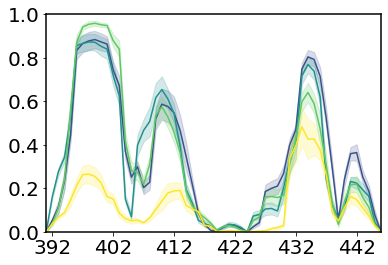

In [111]:
for i in range(1, n_cluster+1):
    key = int(np.where(average_H1_H[:, 2] == i)[0])
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
    plt.plot(hres_renum, H1_H[:, 0], label='C%s' %
             i, color=plt.cm.viridis(round(256/n_cluster)*i))
    plt.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color=plt.cm.viridis(round(256/n_cluster)*i))
plt.ylim(0, 1.0)
plt.xlim(391, 446)
plt.tick_params(labelsize=20)
plt.xticks(np.arange(392, 446, 10))
plt.savefig(all_out_dir + 'helical_fill.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'helical_fill.pdf', dpi=300, bbox_inches='tight')


/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


 Residue  Sheet Propensity
     390              0.00
     391              0.11
     392              0.01
     393              0.02
     394              0.00
     395              0.01
     396              0.00
     397              0.01
     398              0.00
     399              0.00
     400              0.00
     401              0.00
     402              0.57
     403              0.19
     404              0.15
     405              0.82
     406              0.07
     407              0.08
     408              0.17
     409              0.19
     410              0.14
     411              0.08
     412              0.02
     413              0.02
     414              0.04
     415              0.07
     416              0.06
     417              0.07
     418              0.21
     419              0.22
     420              0.14
     421              0.20
     422              0.22
     423              0.58
     424              0.00
     425              0.00
 

/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:653: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


  Cluster  Total Sheet  CYS404 : EPI-002  CYS404 : EPI-7170
1       1         0.02              0.03               0.02
2       2         0.03              0.04               0.02
3       3         0.02              0.03               0.02
4       4         0.11              0.13               0.08


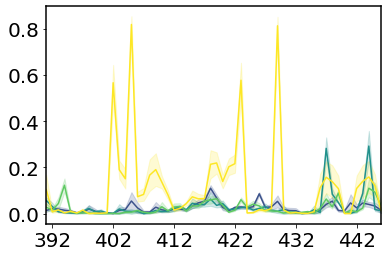

In [118]:
for i in range(1, n_cluster+1):
    key = int(np.where(average_H1_H[:, 2] == i)[0])
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
    plt.plot(hres_renum, H1_E[:, 0], label='C%s' %
             i, color=plt.cm.viridis(round(256/n_cluster)*i))
    plt.fill_between(hres_renum, H1_E[:, 0]-H1_E[:, 1],
                     H1_E[:, 0]+H1_E[:, 1], alpha=0.2, color=plt.cm.viridis(round(256/n_cluster)*i))
# plt.ylim(0, 1.0)
plt.xlim(391, 446)
plt.tick_params(labelsize=20)
plt.xticks(np.arange(392, 446, 10))
plt.savefig(all_out_dir + 'sheet_fill.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'sheet_fill.pdf', dpi=300, bbox_inches='tight')

count = 0
# Initialize the DataFrame with columns for Cluster, Helical Propensity, and systems
df = pd.DataFrame(columns=['Cluster', 'Total Sheet', 'CYS404 : EPI-002', 
                           'CYS404 : EPI-7170'], index=range(1, n_cluster+1))

# Loop through the trajectory data for each system
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    
    for c_num in range(1, n_cluster+1):
        # Find the key for the current cluster
        key = np.where(average_H1_H[:, 2] == c_num)[0][0]
        # c_dist_list = c_dict[key].tolist()
        H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
        if c_num == 4 and i == 0:
            # Define the residue range
            residues = np.arange(390, 448)  # from 390 to 447 inclusive

            # Create a DataFrame to hold the residue numbers and sheet propensity values
            sheet_data = pd.DataFrame({'Residue': residues, 'Sheet Propensity': H1_E[:, 0]})

            # Print the DataFrame without scientific notation
            print(sheet_data.to_string(index=False, float_format='{:0.2f}'.format))        
        # Compute the total helical propensity for the cluster
        df.loc[c_num, 'Total Sheet'] = np.mean(H1_E[:, 0])
        
        # For each system, assign the helical propensity to its corresponding column
        # For example, system 0 is 'CYS404 : EPI-002' and system 1 is 'CYS404 : EPI-7170'
        sele = c_dict[key][(c_dict[key] >= count) & (c_dict[key] < traj_len_array[i]+count)]

        H1_H, H1_E = dssp_convert(dssp_all[sele])
        df.loc[c_num, title_list[i]] = np.mean(H1_E[:, 0])
        
        # Store the cluster number in the 'Cluster' column
        df.loc[c_num, 'Cluster'] = c_num
    count = count + traj_len_array[i]

# Convert to numeric if necessary
df['Total Sheet'] = pd.to_numeric(df['Total Sheet'], errors='coerce')
df['CYS404 : EPI-002'] = pd.to_numeric(df['CYS404 : EPI-002'], errors='coerce')
df['CYS404 : EPI-7170'] = pd.to_numeric(df['CYS404 : EPI-7170'], errors='coerce')

# Round the helical propensities for better readability
df['Total Sheet'] = df['Total Sheet'].round(2)
df['CYS404 : EPI-002'] = df['CYS404 : EPI-002'].round(2)
df['CYS404 : EPI-7170'] = df['CYS404 : EPI-7170'].round(2)

# Print the final DataFrame
print(df)



Text(0.09, 0.5, 'Contact Probability')

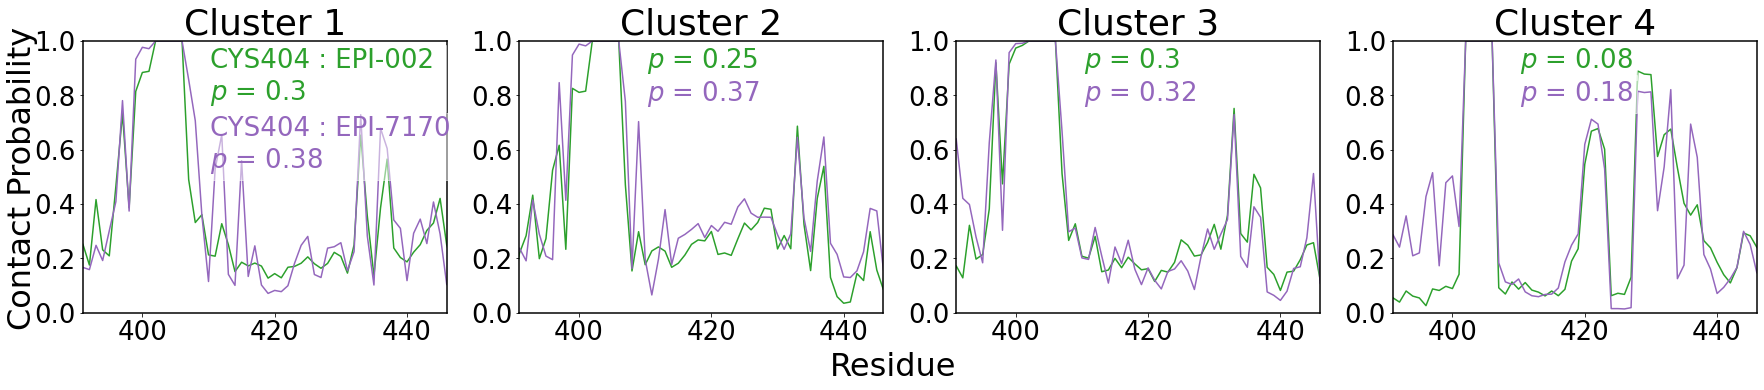

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
# fig.suptitle('Ligand contact', size = 36, y=1)
for i in range(0, n_cluster):
    key = int(np.where(average_H1_H[:, 2] == i+1)[0])
    frame_ind = c_dict[key]
    count = 0
    for ind in range(len(title_list)):
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        count += traj_len_array[ind]
        fig_label = "%s Clsuter population : %s" % (title_list[ind], str(round(df[title_list[ind]][i+1],2)))
        ax[i].plot(hres_renum, np.average(contact_array[frame_new], axis=0), color = color_list[ind], label=fig_label)
    ax[i].set_title('Cluster %s' % str(i+1), size=36)
    # ax[i].legend(loc = 'upper left', bbox_to_anchor=(0, 1.01), fontsize=14, ncol=1)
    ax[i].tick_params(axis='both', labelsize=26)
    ax[i].set_xlim(391, 446)
    ax[i].set_ylim(0, 1.0)
    if i == 0:
        t1 = "%s \n$\it{p}$ = %s" % (str(title_list[0]), str(round(df[title_list[0]][i+1],3)))
        t2 = "%s \n$\it{p}$ = %s" % (str(title_list[1]), str(round(df[title_list[1]][i+1],3)))
        textbox1 = ax[i].text(0.35, 0.8, t1, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[0])
        textbox2 = ax[i].text(0.35, 0.55, t2, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[1])
    else:
        t1 = "$\it{p}$ = %s" % str(round(df[title_list[0]][i+1],3))
        t2 = "$\it{p}$ = %s" % str(round(df[title_list[1]][i+1],3))
        textbox1 = ax[i].text(0.35, 0.9, t1, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[0])
        textbox2 = ax[i].text(0.35, 0.78, t2, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[1])
    textbox1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    textbox2.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
fig.text(0.5, -0.05, 'Residue', ha='center',fontsize=32)
fig.text(0.09, 0.5, 'Contact Probability', va='center', rotation='vertical',fontsize=32)

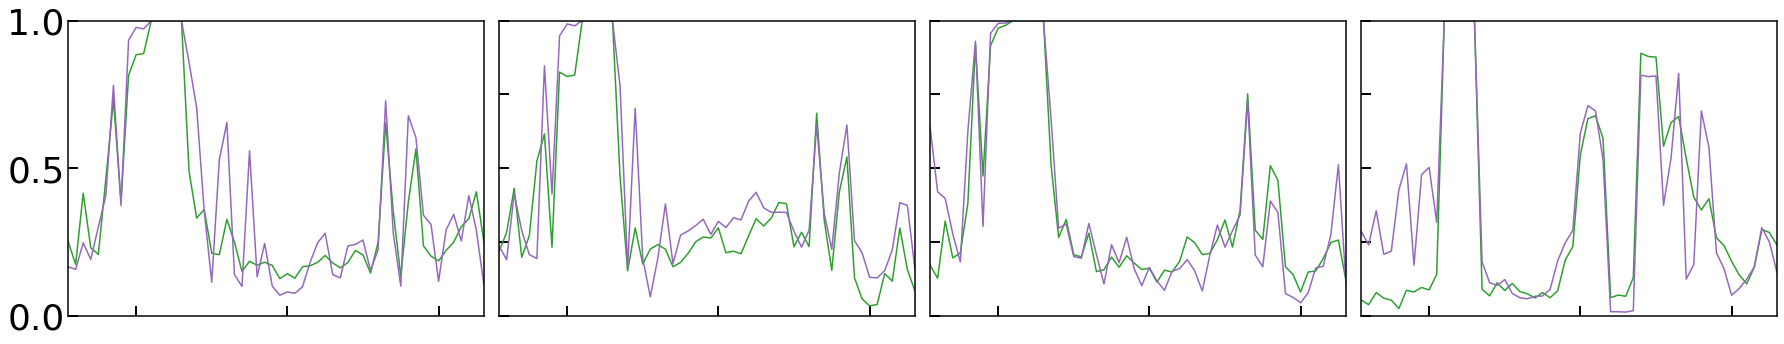

In [99]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
# fig.suptitle('Ligand contact', size = 36, y=1)
for i in range(0, n_cluster):
    key = int(np.where(average_H1_H[:, 2] == i+1)[0])
    frame_ind = c_dict[key]
    count = 0
    y = []  
    for ind in range(len(title_list)):
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        count += traj_len_array[ind]
        y.append(np.average(contact_array[frame_new], axis=0))
        fig_label = "%s Clsuter population : %s" % (title_list[ind], str(round(df[title_list[ind]][i+1],2)))
        ax[i].plot(hres_renum, np.average(contact_array[frame_new], axis=0), color = color_list[ind], label=fig_label)
    r2 = sp.stats.pearsonr(y[0], y[1])[0] ** 2 
    t1 = "$R^2$ = %s" % (str(round(r2, 2)))
    ax[i].tick_params(axis='both', labelsize=36)
    ax[i].set_xlim(391, 446)
    ax[i].set_ylim(0, 1.0)

    if i > 0:
        ax[i].tick_params(axis='both', labelsize=36, direction = 'in', labelbottom=False, labelleft = False, length=10, width = 2)
    else:
        ax[i].tick_params(axis='both', labelsize=36, direction = 'in', labelbottom=False, labelleft = True, length=10, width = 2)
        ax[i].set_yticks([0, 0.5, 1.0])

plt.tight_layout()
plt.savefig(all_out_dir + 'contact_correlation.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'contact_correlation.pdf', dpi=300, bbox_inches='tight')

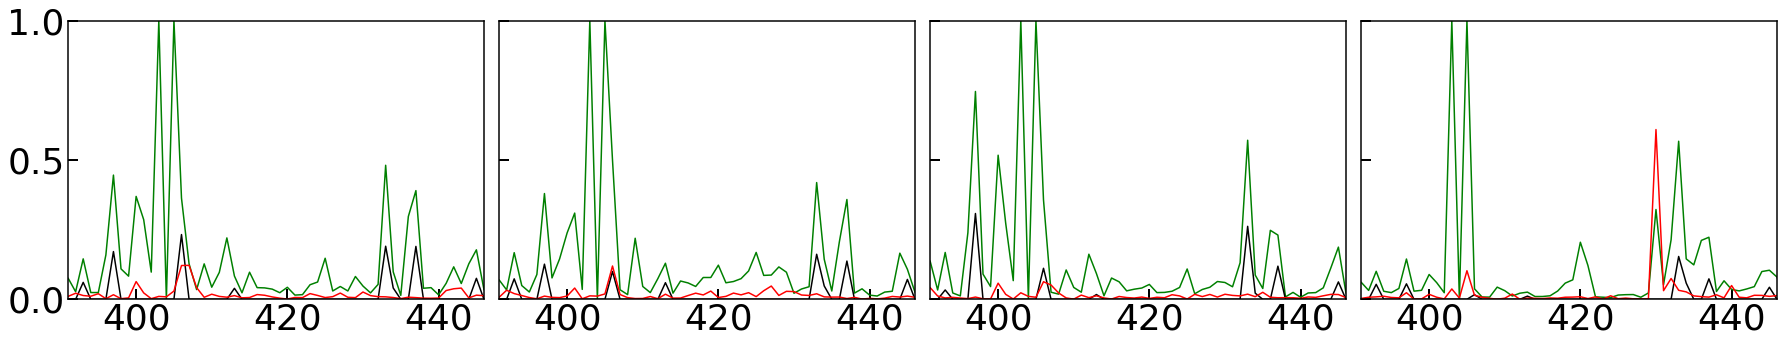

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
# fig.suptitle('Ligand contact', size = 36, y=1)

for i in range(0, n_cluster):
    key = int(np.where(average_H1_H[:, 2] == i+1)[0])
    frame_ind = c_dict[key]
    ax[i].plot(hres_renum, np.average(hphob_array[frame_ind], axis=0), color = 'green', label = 'Hydrophobic Contacts')
    ax[i].plot(hres_renum, np.average(aromatic_array[frame_ind], axis=0), color = 'black', label = 'Aromatic Stacking')
    ax[i].plot(hres_renum, np.average(hbond_array[frame_ind], axis=0), color = 'red', label = 'Hydrogen Bonds')    
 
    ax[i].tick_params(axis='both', labelsize=36)
    ax[i].set_xlim(391, 446)
    ax[i].set_ylim(0, 1.0)
    if i > 0:
        ax[i].tick_params(axis='both', labelsize=36, direction = 'in', labelbottom=True, labelleft = False, length=10, width = 2)
        ax[i].set_yticklabels([])
    else:
        ax[i].tick_params(axis='both', labelsize=36, direction = 'in', labelbottom=True, labelleft = True, length=10, width = 2)

plt.tight_layout()
plt.savefig(all_out_dir + 'ligand_contact.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'ligand_contact.pdf', dpi=300, bbox_inches='tight')

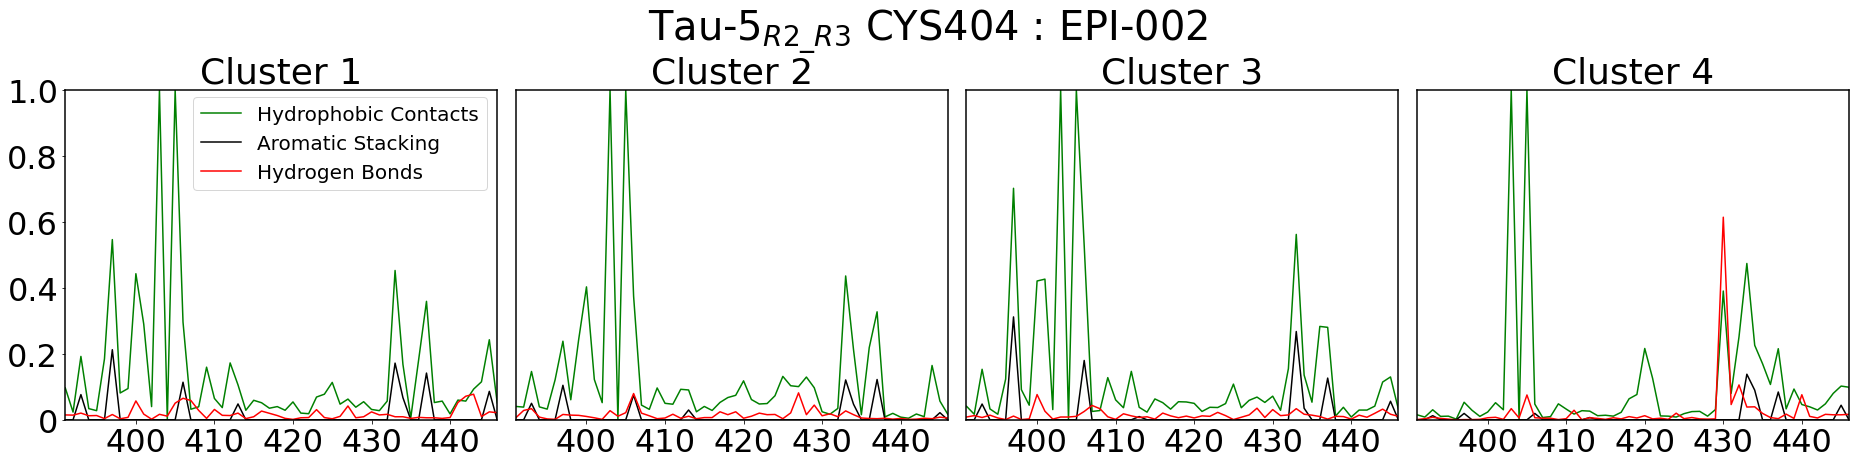

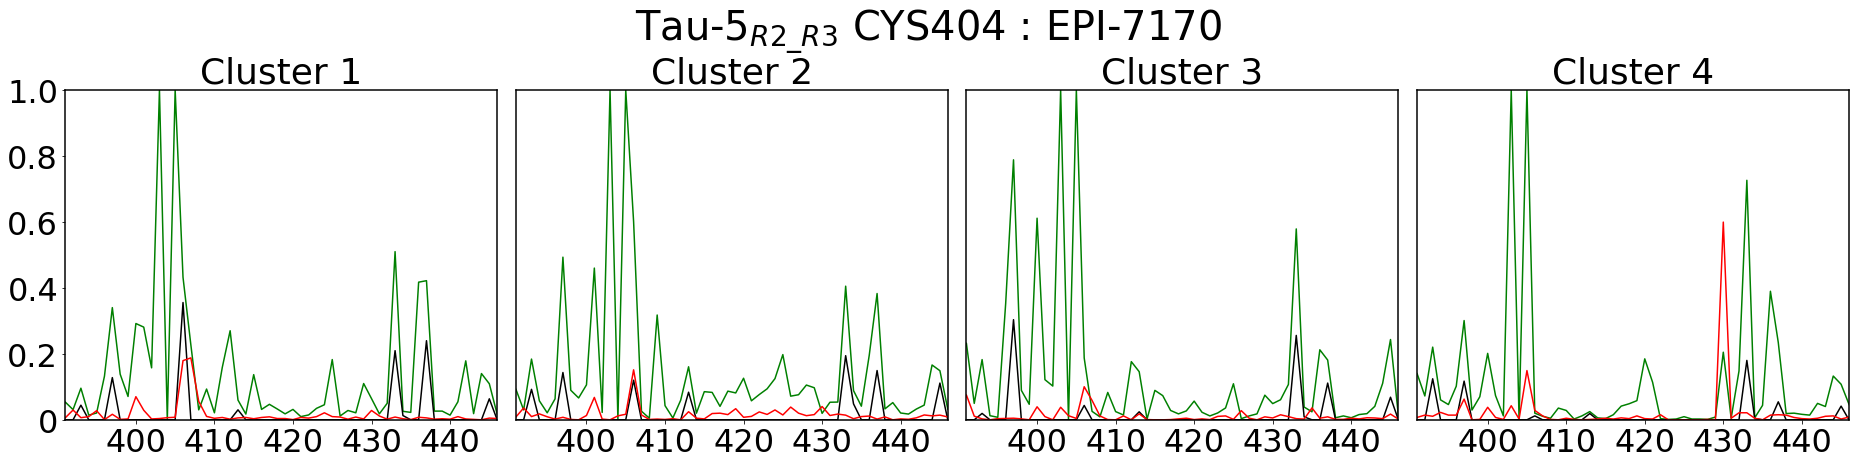

In [31]:
count = 0
np.set_printoptions(precision=2)
for ind in range(len(title_list)):
    fig, ax = plt.subplots(1, 4, figsize=(26, 6))
    ax = ax.flatten()
    for i in range(0, n_cluster):
        key = int(np.where(average_H1_H[:, 2] == i+1)[0])
        frame_ind = c_dict[key]
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        ax[i].set_title('Cluster %s' % str(i+1), size=36)
        ax[i].tick_params(axis='both', labelsize=20)
        ax[i].set_xlim(391, 446)
        ax[i].set_ylim(0, 1)
        if i > n_cluster-5:
            ax[i].set_xticklabels(size = 32, labels = ([390, 400, 410, 420, 430, 440]))
        else:
            ax[i].set_xticks([])
        if i % 4 == 0:
            ax[i].set_yticklabels(size = 32, labels = ([0, 0.2, 0.4, 0.6, 0.8, 1.0]))
        else:
            ax[i].set_yticks([])
        ax[i].plot(hres_renum, np.average(hphob_array[frame_new], axis=0), color = 'green', label = 'Hydrophobic Contacts')
        ax[i].plot(hres_renum, np.average(aromatic_array[frame_new], axis=0), color = 'black', label = 'Aromatic Stacking')
        ax[i].plot(hres_renum, np.average(hbond_array[frame_new], axis=0), color = 'red', label = 'Hydrogen Bonds')    
        if ind == 0:
            ax[0].legend(fontsize = 20, loc = 'upper right', bbox_to_anchor=(1, 1.01))
    fig.suptitle(r'Tau-5$_{R2\_R3}$ %s' % title_list[ind], size = 40, y=1.08)
    count += traj_len_array[ind]
    fig.tight_layout()
    plt.savefig(all_out_dir + 'ligand_interaction_%s.png'% title_list[ind], dpi=300, bbox_inches='tight')
    plt.savefig(all_out_dir + 'ligand_interaction_%s.pdf'% title_list[ind], dpi=300, bbox_inches='tight')

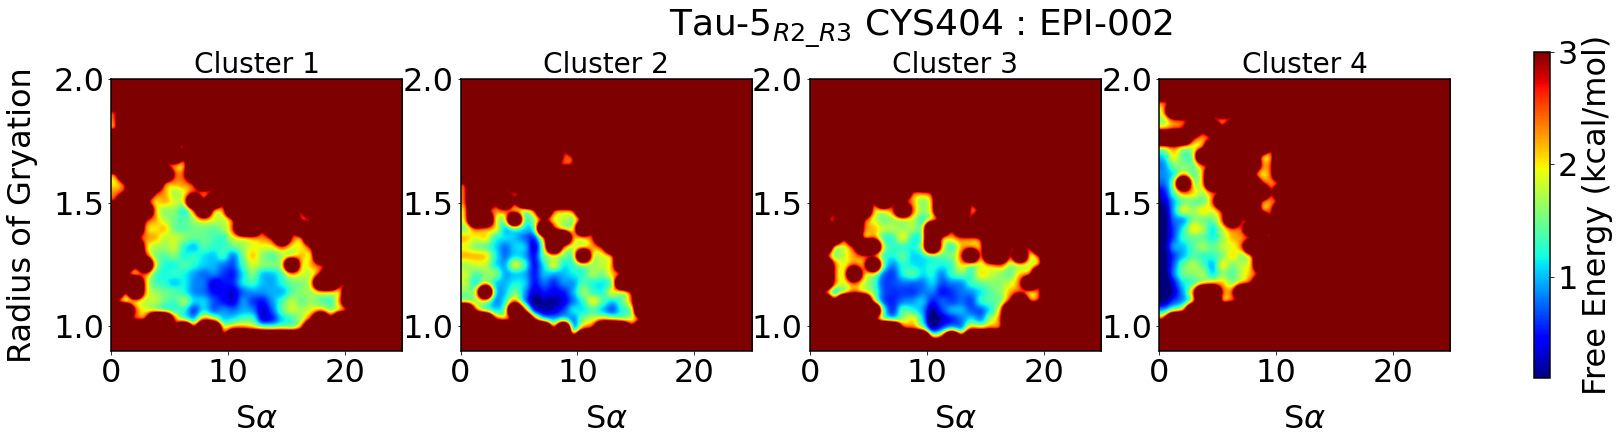

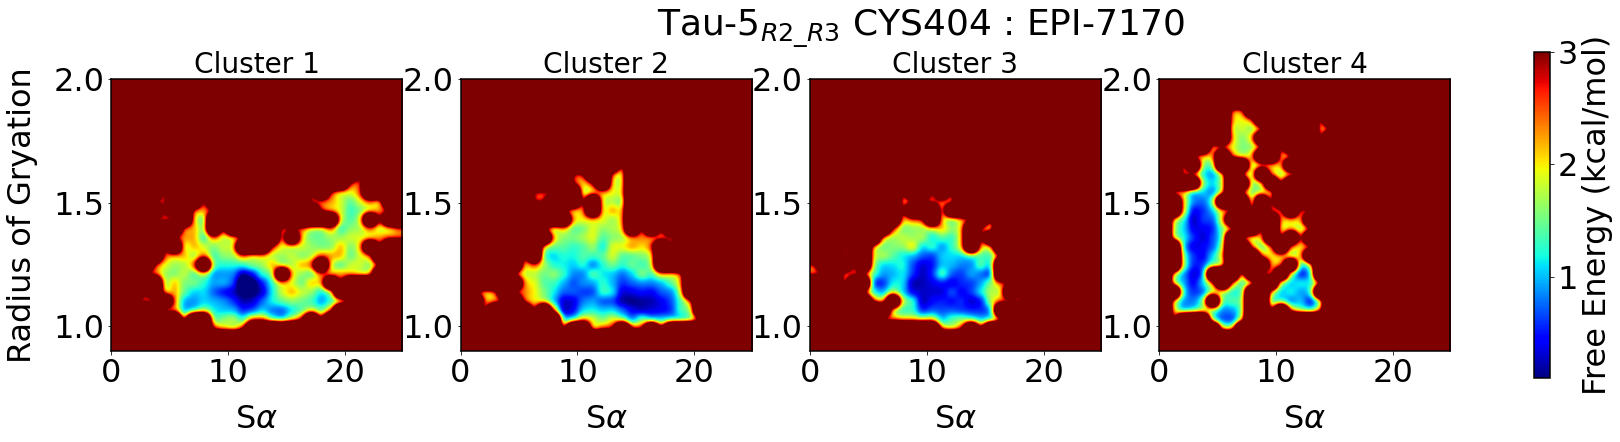

In [24]:
count = 0
for ind in range(len(title_list)):
    fig, ax = plt.subplots(1, 4, figsize=(30, 5))
    ax = ax.flatten()
    for i in range(0, n_cluster):
        key = int(np.where(average_H1_H[:, 2] == i+1)[0])
        frame_ind = c_dict[key]
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        a, xedges, yedges = np.histogram2d(rg_CA[frame_new], Sa_total[frame_new], 30, [
            [0.9, 2], [0, 25.0]], normed=True, weights=None)
        a = np.log(np.flipud(a)+.000001)
        T = 300
        a = -(0.001987*T)*a

        im = ax[i].imshow(a, interpolation='gaussian', extent=[
            yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
        im.set_clim(0.1, 3)
        ax[i].set_xlim(0, 24.9)
        if i % 4 == 0:
            ax[i].set_ylabel("Radius of Gryation", size=32, labelpad=15)
        if i > n_cluster - 5:
            ax[i].set_xlabel(r'S$\alpha$', size=32, labelpad=15)
        ax[i].set_title('Cluster %s' %
                                    str(i+1), fontsize=28)
        ax[i].tick_params(axis='both', labelsize=32)

    # Add a color bar on the right side of the figure
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink = 1.2, orientation='vertical')
    cbar.set_label('Free Energy (kcal/mol)', size=32)
    cbar.ax.tick_params(labelsize=32)

    fig.suptitle(r'Tau-5$_{R2\_R3}$ %s' % title_list[ind], size = 36, y=1.08)
    count += traj_len_array[ind]
    # fig.tight_layout()
    plt.savefig(all_out_dir + 'SaRg_%s.png'% title_list[ind], dpi=300, bbox_inches='tight')
    plt.savefig(all_out_dir + 'SaRg_%s.pdf'% title_list[ind], dpi=300, bbox_inches='tight')

/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/home/daisy/.conda/envs/labconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


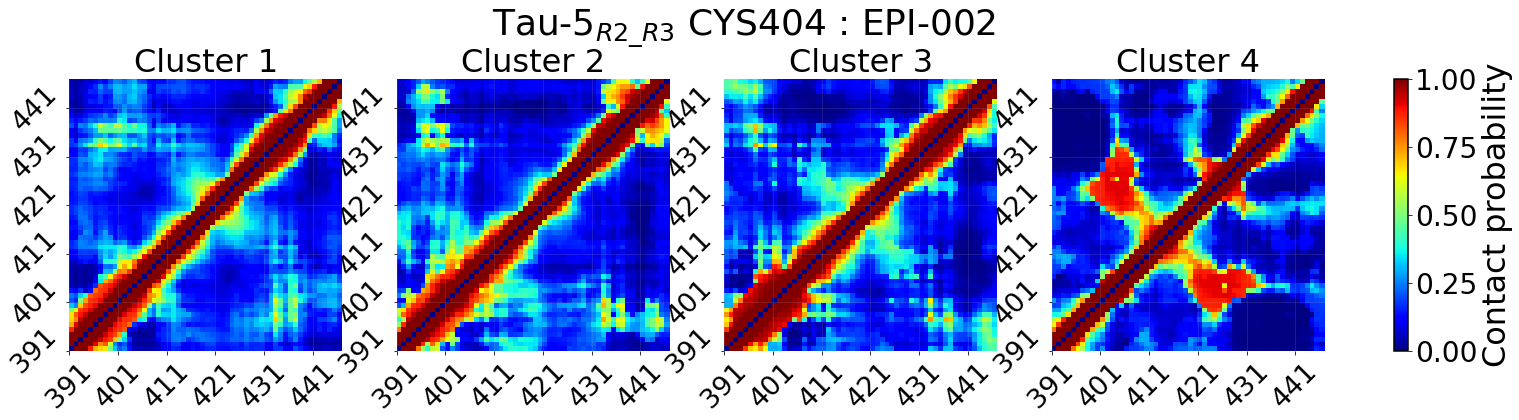

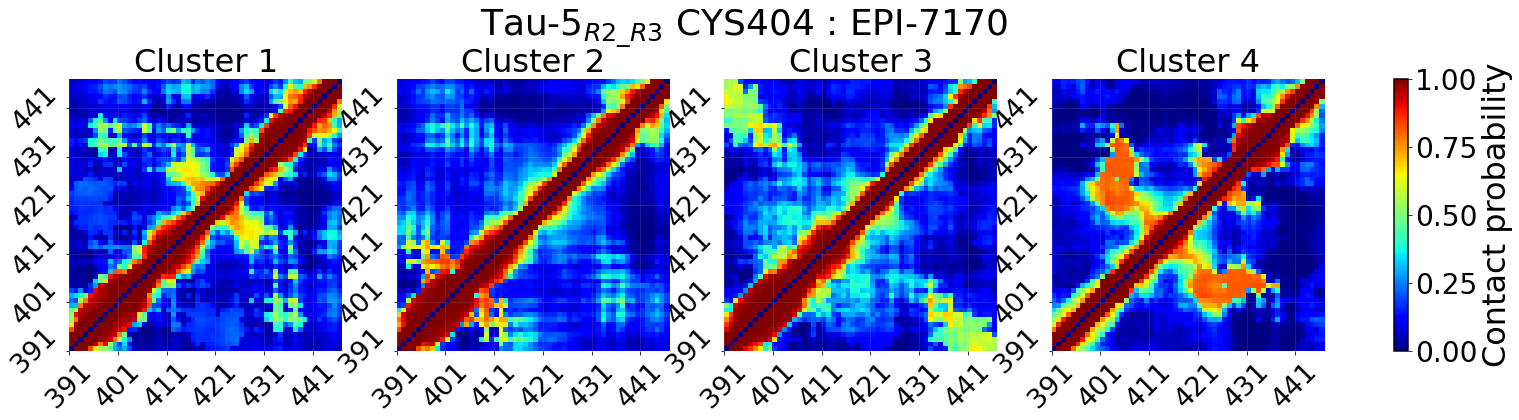

In [30]:
sequence = []
for i in range(1, 57):
    new_i = i+390
    if i % 10 == 1:
        sequence.append(str(new_i))

count = 0
for ind in range(len(title_list)):
    fig, ax = plt.subplots(1,4, figsize=(25, 5))
    ax = ax.flatten()
    for i in range(0, n_cluster):
        key = int(np.where(average_H1_H[:, 2] == i+1)[0])
        frame_ind = c_dict[key]
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        axis = ax[i]
        plt.sca(axis)
        contact_map_CA = calc_contact_map_CA(traj_CA_combined[frame_new])
        im = sns.heatmap(contact_map_CA, cmap='jet', ax=axis, cbar=False)
        axis.invert_yaxis()
        plt.grid(which='both', alpha=0.2)
        plt.xticks(np.arange(0, 56, 10), sequence, rotation = 45, fontsize=27)
        plt.yticks(np.arange(0, 56, 10), sequence, rotation = 45, fontsize=27)
        plt.title('Cluster %s' % str(i+1), fontsize=32)
    # fig.tight_layout()
    cbar = fig.colorbar(im.get_children()[0], ax=ax.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.05)
    cbar.set_label('Contact probability', size=32)
    cbar.ax.tick_params(labelsize=28)
    cbar.set_clim(0, 1)

    fig.suptitle(r'Tau-5$_{R2\_R3}$ %s' % title_list[ind], size = 36, y=1.08)
    count += traj_len_array[ind]
    plt.savefig(all_out_dir + 'contact_map_%s.png'% title_list[ind], dpi=300, bbox_inches='tight')
    plt.savefig(all_out_dir + 'contact_map_%s.pdf'% title_list[ind], dpi=300, bbox_inches='tight')